1. Import Tensorflow and test CPU and GPU setup.

In [ ]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
# Verify CPU Setup
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
# Verify GPU Setup
if (len(tf.config.list_physical_devices('GPU')) == 0):
    print("No GPU available")
else:
    print(tf.config.list_physical_devices('GPU'))

%pip install -r requirements.txt

2025-03-03 06:32:15.540496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740954735.585530    7336 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740954735.596961    7336 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 06:32:15.670800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version:  2.18.0
tf.Tensor(-669.91003, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1740954737.635671    7336 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4148 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2. Import & pre-process dataset

In [142]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation
import os
print("Current working directory: ", os.getcwd())

import ahrs

# Load the The Zurich Urban Micro Aerial Vehicle Dataset
# https://www.kaggle.com/datasets/mrisdal/zurich-urban-micro-aerial-vehicle?resource=download&select=readme.txt
# -> We will take the timestamps, raw accel, orientation and position data only.

## Preprocess ground truth data
# Load CSV files
ground_truth_AGL_csv = pd.read_csv('./datasets/Zurich/raw/GroundTruthAGL.csv')
ground_truth_AGL_csv.columns = ground_truth_AGL_csv.columns.str.strip()
ground_truth_AGM_csv = pd.read_csv('./datasets/Zurich/raw/GroundTruthAGM.csv')
ground_truth_AGM_csv.columns = ground_truth_AGM_csv.columns.str.strip()
# Combine dataset files
merged_ground_truth_csv = pd.merge(ground_truth_AGM_csv, ground_truth_AGL_csv, on='imgid', how='inner')
ground_truth_csv = merged_ground_truth_csv[["Timpstemp", "x_gt", "y_gt", "z_gt"]]
ground_truth_csv = ground_truth_csv.sort_values(by="Timpstemp")

## Preprocess sensor data
# Load CSV files
sensor_data_full_csv = pd.read_csv('./datasets/Zurich/raw/OnboardPose.csv')
sensor_data_full_csv.columns = sensor_data_full_csv.columns.str.strip()
sensor_data_csv = sensor_data_full_csv[[
    "Timpstemp", "Accel_x", "Accel_y", "Accel_z", 
    "Attitude_w", "Attitude_x", "Attitude_y", "Attitude_z"
]]
sensor_data_csv = sensor_data_csv.sort_values(by="Timpstemp")



print("Removing gravity vector from sensor accelerometer data")
gravity = np.array([0, 0, 9.81])
def remove_gravity(row):
    q = np.array([row["Attitude_w"], row["Attitude_x"], row["Attitude_y"], row["Attitude_z"]])
    q /= np.linalg.norm(q) # Normalize quaternion to avoid errors
    # Convert quaternion to rotation matrix
    r = Rotation.from_quat(q[[1, 2, 3, 0]])
    gravity_rotated = r.inv().apply(gravity)
    # Remove gravity vector from accelerometer data
    return np.array([row["Accel_x"], row["Accel_y"], row["Accel_z"]]) - gravity_rotated
sensor_data_csv[["Accel_x", "Accel_y", "Accel_z"]] = sensor_data_csv.apply(remove_gravity, axis=1, result_type='expand')



#! none of the timestamps match, so we will have to interpolate the ground truth data
# Interpolate ground truth data
print("Interpolating ground truth data")
ground_truth_interpolated_csv = pd.merge_asof(sensor_data_csv["Timpstemp"], ground_truth_csv, on="Timpstemp", direction="nearest")
ground_truth_interpolated_csv.loc[:,'x_gt':'z_gt'] = ground_truth_interpolated_csv.loc[:,'x_gt':'z_gt'].mask(ground_truth_interpolated_csv.loc[:,'x_gt':'z_gt'].duplicated(), pd.NA)
ground_truth_interpolated_csv = ground_truth_interpolated_csv.interpolate(method='linear')
ground_truth_interpolated_csv = ground_truth_interpolated_csv.sort_values(by="Timpstemp")
# ground_truth_interpolated_csv.to_csv('./datasets/Zurich/preprocessed/ground_truth_interpolated.csv', index=False)

# reset frame for ground truth data
print("Resetting frame for ground truth data")
first_row = ground_truth_interpolated_csv.iloc[0]
ground_truth_interpolated_csv['x_gt'] = ground_truth_interpolated_csv['x_gt'] - first_row['x_gt']
ground_truth_interpolated_csv['y_gt'] = ground_truth_interpolated_csv['y_gt'] - first_row['y_gt']
ground_truth_interpolated_csv['z_gt'] = ground_truth_interpolated_csv['z_gt'] - first_row['z_gt']

# calculate ground truth velocities
print("Calculating ground truth velocities")
ground_truth_interpolated_csv["vx_gt"] = ground_truth_interpolated_csv["x_gt"].diff().fillna(0) / (ground_truth_interpolated_csv['Timpstemp'].diff().fillna(0) * 1e-6)
ground_truth_interpolated_csv["vy_gt"] = ground_truth_interpolated_csv["y_gt"].diff().fillna(0) / (ground_truth_interpolated_csv['Timpstemp'].diff().fillna(0) * 1e-6)
ground_truth_interpolated_csv["vz_gt"] = ground_truth_interpolated_csv["z_gt"].diff().fillna(0) / (ground_truth_interpolated_csv['Timpstemp'].diff().fillna(0) * 1e-6)

# Save ground truth data to a new CSV file
ground_truth_interpolated_csv.to_csv('./datasets/Zurich/preprocessed/ground_truth.csv', index=False)
print("Ground truth data saved to ground_truth.csv")

# Compute OF deltas from ground truth data
print("Computing OF deltas from ground truth data")
ground_truth_interpolated_csv["Delta_x"] = ground_truth_interpolated_csv["x_gt"].diff().fillna(0)
ground_truth_interpolated_csv["Delta_y"] = ground_truth_interpolated_csv["y_gt"].diff().fillna(0)
ground_truth_interpolated_csv["Delta_z"] = ground_truth_interpolated_csv["z_gt"].diff().fillna(0)

# Add OF deltas
sensor_data_csv["Delta_x"] = ground_truth_interpolated_csv["Delta_x"]
sensor_data_csv["Delta_y"] = ground_truth_interpolated_csv["Delta_y"]
sensor_data_csv["Delta_z"] = ground_truth_interpolated_csv["Delta_z"]


#! here consider adding the OF deltas and only suppling the OF deltas every 10 timesteps
def accumulate(sensor_data_csv, ground_truth_csv):
    print("Accumulating deltas")

    # Initialize cumulative deltas
    cumulative_delta_x = 0
    cumulative_delta_y = 0
    cumulative_delta_z = 0

    # Iterate over the sensor data
    for i in range(len(sensor_data_csv)):

        cumulative_delta_x += sensor_data_csv["Delta_x"].iloc[i]
        cumulative_delta_y += sensor_data_csv["Delta_y"].iloc[i]
        cumulative_delta_z += sensor_data_csv["Delta_z"].iloc[i]

        if i % 10 == 0 and i != 0:
            # Set the cumulative delta for every 10th timestep
            sensor_data_csv.at[i, "Delta_x"] = cumulative_delta_x
            sensor_data_csv.at[i, "Delta_y"] = cumulative_delta_y
            sensor_data_csv.at[i, "Delta_z"] = cumulative_delta_z
            # Reset cumulative deltas
            cumulative_delta_x = 0
            cumulative_delta_y = 0
            cumulative_delta_z = 0
        else:
            # Set Delta_x and Delta_y to NaN for other timesteps
            sensor_data_csv.at[i, "Delta_x"] = np.nan
            sensor_data_csv.at[i, "Delta_y"] = np.nan
            sensor_data_csv.at[i, "Delta_z"] = np.nan

# Call the accumulate function
accumulate(sensor_data_csv, ground_truth_csv)

# Save sensor data to a new CSV file
sensor_data_csv.to_csv('./datasets/Zurich/preprocessed/sensor_data.csv', index=False)
print("Sensor data saved to sensor_data.csv")


print("Preprocessing done")

Current working directory:  /home/luigipizzolito/Documents/GitHub/OF_IMU-LocationCore/LSTM-TensorFlow
Removing gravity vector from sensor accelerometer data
Interpolating ground truth data
Resetting frame for ground truth data
Calculating ground truth velocities
Ground truth data saved to ground_truth.csv
Computing OF deltas from ground truth data
Accumulating deltas
Sensor data saved to sensor_data.csv
Preprocessing done


4. Run Kalman filter and plot results, using Zurich drone dataset

Optimising initial Kalman filter parameters
Simulating params:  0.1 0.001 0.01 Loss:  0.41476341515402626
Simulating params:  0.11 0.001 0.01 Loss:  0.4244549598921019
Simulating params:  0.1 0.0011 0.01 Loss:  0.41476243952044584
Simulating params:  0.1 0.001 0.011 Loss:  0.40923081071977124
Simulating params:  0.09 0.0010666664 0.010666668 Loss:  0.4076694425618307
Simulating params:  0.083333336 0.0010888886 0.010888891 Loss:  0.409041855282369
Simulating params:  0.09333333 0.0011111108 0.01111111 Loss:  0.40764992672135825
Simulating params:  0.0911111 0.0011481477 0.011481481 Loss:  0.40810072242658235
Simulating params:  0.08888889 0.0010185183 0.011851853 Loss:  0.4097787949707527
Simulating params:  0.091203704 0.0010354937 0.0114660505 Loss:  0.4080573360418138
Simulating params:  0.08302469 0.0011421806 0.011162551 Loss:  0.4101242615659955
Simulating params:  0.09646348 0.001029621 0.011033865 Loss:  0.40811919667482416
Simulating params:  0.08656121 0.0011125597 0.01112868

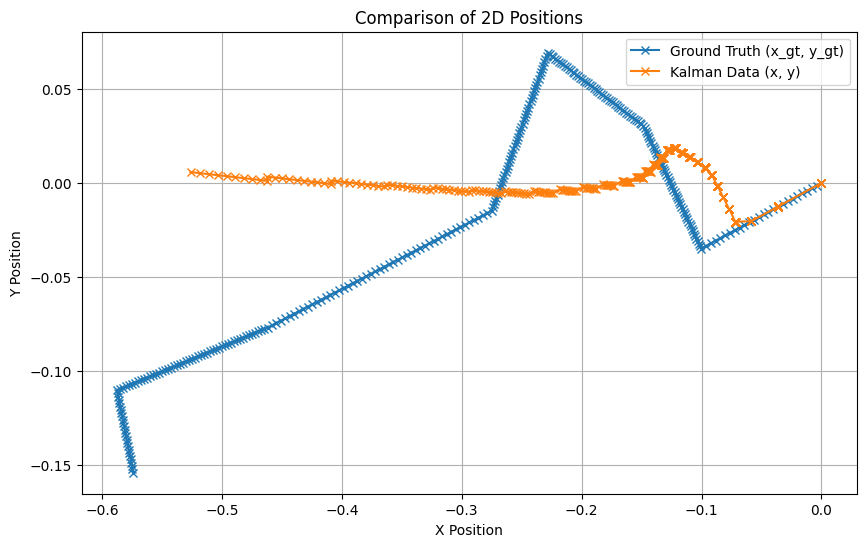

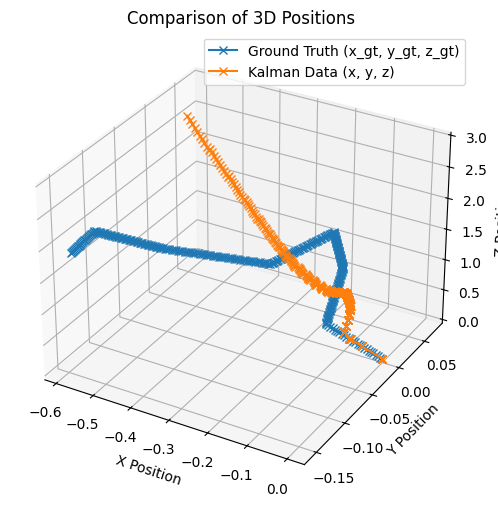

In [36]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import tensorflow as tf

class KalmanFilter:
    def __init__(self, KF_INIT_P, KF_INIT_Q, KF_INIT_R):
        """
        Initialize a Kalman Filter.

        Parameters:
        - 6: State vector size
        - 3: Measurement vector size
        """
        
        self.x = np.zeros((6, 1))  # State estimate (initialized to zero)
        # self.past_x = np.zeros((6, 9))  # Past state estimates
        self.past_x = [np.zeros((6, 1)) for _ in range(9)]
        self.P = np.eye(6) * KF_INIT_P  # Initial State uncertainty
        self.Q = np.eye(3) * KF_INIT_Q  # Initial Process noise
        self.R = np.eye(3) * KF_INIT_R  # Initial Measurement noise

        # Initial state transition noise matrix
        dt = 0.020 # assuming 20ms time step
        G = np.array([[0.5*dt*dt, 0, 0],
                      [0, 0.5*dt*dt, 0],
                      [0, 0, 0.5*dt*dt],
                      [dt, 0, 0],
                      [0, dt, 0],
                      [0, 0, dt]])
        self.Qd = np.dot(G, np.dot(self.Q, G.T))

        # Initial and constant Jacobian matrices
        self.A = np.array([
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0]
        ])
        self.C = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0]
        ])

        self.f = np.zeros((6, 1))
        self.h = np.zeros((3, 1))

    def set_initial_state(self, x):
        self.x = x


    def predict(self, quat, accel, dt):

        # 1. Rotate the acceleration vector to the global frame
        # 1.1 Convert the quaternion to a rotation matrix
        q0, q1, q2, q3 = quat
        R = np.array([
            [1 - 2*q2*q2 - 2*q3*q3, 2*q1*q2 - 2*q0*q3, 2*q1*q3 + 2*q0*q2],
            [2*q1*q2 + 2*q0*q3, 1 - 2*q1*q1 - 2*q3*q3, 2*q2*q3 - 2*q0*q1],
            [2*q1*q3 - 2*q0*q2, 2*q2*q3 + 2*q0*q1, 1 - 2*q1*q1 - 2*q2*q2]
        ])
        # 1.2 Rotate the acceleration vector
        accel = np.dot(R, accel)

        # ZUPT detection
        if np.linalg.norm(accel) < 0.1:
            accel = np.zeros((3, 1))
            self.x[3:6] = np.zeros((3, 1))

        # print("p1: Dimensions of self.x: ", self.x.shape)

        # 2. Update the current state prediction
        # 2.1 Update f
        self.f[0:3,0] = self.x[3:6,0] * dt + 0.5 * accel * dt * dt
        self.f[3:6,0] = self.x[3:6,0] + accel * dt
        # 2.2 Update x
        # self.past_x = np.roll(self.past_x, 1, axis=1)
        # for i in range(8,1):
        #     self.past_x[:, i] = self.past_x[:, i-1]
        # self.past_x[:, 0] = self.x[:, 0]
        self.past_x.pop()
        self.past_x.insert(0, self.x.copy())
        # print(self.past_x)

        self.x = self.x + dt * self.f

        # print("p2: Dimensions of self.x: ", self.x.shape)

        # 3. Update the error covariance matrix
        # 3.1 Update A
        # 3.2 Update P
        # self.P = np.dot(self.A, np.dot(self.P, self.A.T)) + self.Qd
        self.P = self.P + dt*( np.dot(self.A, self.P) + np.dot(self.P, self.A.T) + self.Qd )


    def update(self, quat, of): #? we dont care about dt for this one
        
        # 1. Project OF data to global 3D frame
        # 1.1 Convert the quaternion to a rotation matrix
        # q0, q1, q2, q3 = quat
        # R = np.array([
        #     [1 - 2*q2*q2 - 2*q3*q3, 2*q1*q2 - 2*q0*q3, 2*q1*q3 + 2*q0*q2],
        #     [2*q1*q2 + 2*q0*q3, 1 - 2*q1*q1 - 2*q3*q3, 2*q2*q3 - 2*q0*q1],
        #     [2*q1*q3 - 2*q0*q2, 2*q2*q3 + 2*q0*q1, 1 - 2*q1*q1 - 2*q2*q2]
        # ])
        # 1.2 Rotate the optical flow vector
        # of_z = np.array([[of[0]], [of[1]], [0]]) #! trying a 3d delta as this is drone data
        of_z = np.array([[of[0]], [of[1]], [of[2]]])
        # of_z = of
        # of_g = np.dot(R, of_z)    #! for drone this data is not relative to the drone, but global
        of_g = of_z

        # 2. Compute Kalman Gain
        self.K = np.dot( self.P, np.dot(self.C.T, np.linalg.inv(np.dot(self.C, np.dot(self.P, self.C.T)) + self.R)) )
        # print("K: ", self.K)

        # 3. Update current state estimate
        # 3.1 Update h
        self.h = self.x[0:3] - self.past_x[8][0:3] # here we take difference from the state 9 steps ago
        # 3.2 Update x
        # print("u1: Dimensions of self.x: ", self.x.shape)
        # print("K: ", self.K.shape)
        # print("of_g: ", of_g.shape)
        # print("x[0:3]: ", self.x[0:3].shape)
        # print("past_x[0:3, 8]: ", self.past_x[8][0:3].shape)
        # print("h: ", self.h.shape)
        # print("y-h: ", (of_g - self.h).shape)
        # print("K*(y-h): ", np.dot(self.K, (of_g -self.h)).shape)
        self.x = self.x + np.dot(self.K, (of_g - self.h))
        # print("u2: Dimensions of self.x: ", self.x.shape)

        # 4. Update the error covariance matrix
        self.P = np.dot( np.eye(6) - np.dot(self.K, self.C), self.P )


def kalman_round(KF_INIT_P, KF_INIT_Q, KF_INIT_R, ground_truth_csv, sensor_data_csv, save_csv=False):
    # Clone of embedded Kalman Filter implemntation
    # State: x, y, z, vx, vy, vz
    # Measurement: dx, dy, dz
    kf = KalmanFilter(KF_INIT_P, KF_INIT_Q, KF_INIT_R) 

    # print("Kalman Filter model initialized")
    

    # load preprocessed data
    # Use a 'with' block to ensure files are closed
    # with open('./datasets/Zurich/preprocessed/ground_truth.csv', 'r') as gt_file, \
    #      open('./datasets/Zurich/preprocessed/sensor_data.csv', 'r') as sensor_file:
    #     ground_truth_csv = pd.read_csv(gt_file)
    #     sensor_data_csv = pd.read_csv(sensor_file)

    kalman_out = []

    # # Set Kalman filter initial state
    # initial_data = sensor_data_csv.iloc[0]
    # kf.set_initial_state()

    # Simulate Kalman filter for the first 50 steps
    for i in range(0, 300+1):
        # print("Step: ", i)
        # Get the current sensor data
        sensor_data = sensor_data_csv.iloc[i]
        quat = np.array([sensor_data["Attitude_w"], sensor_data["Attitude_x"], sensor_data["Attitude_y"], sensor_data["Attitude_z"]])
        accel = np.array([sensor_data["Accel_x"], sensor_data["Accel_y"], sensor_data["Accel_z"]])
        if i == 0:
            dt = 0.020
        else:
            dt = (sensor_data_csv.iloc[i]["Timpstemp"] - sensor_data_csv.iloc[i-1]["Timpstemp"]) / 1e6  # Convert microseconds to seconds
        # print current sensor data
        # print("Sensor data: ", sensor_data.to_dict())
        # print("dt: ", dt)

        # Predict the state
        kf.predict(quat, accel, dt)
        # Print prediction state
        # print("Prediction state: ", kf.x.tolist())

        # # Get the current ground truth data
        # ground_truth_data = ground_truth_csv.iloc[i]
        of = np.array([sensor_data["Delta_x"], sensor_data["Delta_y"], sensor_data["Delta_z"]])
        if np.isnan(of).any():
            kalman_out.append({
                'Timestamp': sensor_data["Timpstemp"],
                'x': kf.x[0].item(), 'y': kf.x[1].item(), 'z': kf.x[2].item(),
                'vx': kf.x[3].item(), 'vy': kf.x[4].item(), 'vz': kf.x[5].item(),
                'P': kf.P.tolist(), 'K': np.nan
            })
            # print()
            continue
        else:
            # Update the state
            kf.update(quat, of)
            # Print updated state
            # print("Updated state: ", kf.x.tolist())
            kalman_out.append({
                'Timestamp': sensor_data["Timpstemp"],
                'x': kf.x[0].item(), 'y': kf.x[1].item(), 'z': kf.x[2].item(),
                'vx': kf.x[3].item(), 'vy': kf.x[4].item(), 'vz': kf.x[5].item(),
                'P': kf.P.tolist(), 'K': kf.K.tolist()
            })
            # print()

    # Save Kalman filter output to a new CSV file
    kalman_out_csv = pd.DataFrame(kalman_out)

    first_row = kalman_out_csv.iloc[0]
    kalman_out_csv['x'] = kalman_out_csv['x'] - first_row['x']
    kalman_out_csv['y'] = kalman_out_csv['y'] - first_row['y']
    kalman_out_csv['z'] = kalman_out_csv['z'] - first_row['z']

    kalman_out_csv['x_gt'] = ground_truth_csv['x_gt']
    kalman_out_csv['y_gt'] = ground_truth_csv['y_gt']
    kalman_out_csv['z_gt'] = ground_truth_csv['z_gt']
    kalman_out_csv['vx_gt'] = ground_truth_csv['vx_gt']
    kalman_out_csv['vy_gt'] = ground_truth_csv['vy_gt']
    kalman_out_csv['vz_gt'] = ground_truth_csv['vz_gt']

    kalman_out_csv['error_x'] = kalman_out_csv['x'] - kalman_out_csv['x_gt']
    kalman_out_csv['error_y'] = kalman_out_csv['y'] - kalman_out_csv['y_gt']
    kalman_out_csv['error_z'] = kalman_out_csv['z'] - kalman_out_csv['z_gt']
    kalman_out_csv['error_vx'] = kalman_out_csv['vx'] - kalman_out_csv['vx_gt']
    kalman_out_csv['error_vy'] = kalman_out_csv['vy'] - kalman_out_csv['vy_gt']
    kalman_out_csv['error_vz'] = kalman_out_csv['vz'] - kalman_out_csv['vz_gt']

    if save_csv:
        kalman_out_csv.to_csv('./datasets/Zurich/kalman_out/kalman.csv', index=False)
    # return kalman_out_csv

    # Compute RMSE for each error column
    rmse_x = np.sqrt(mean_squared_error(kalman_out_csv['x_gt'][1:], kalman_out_csv['x'][1:]))
    rmse_y = np.sqrt(mean_squared_error(kalman_out_csv['y_gt'][1:], kalman_out_csv['y'][1:]))
    rmse_z = np.sqrt(mean_squared_error(kalman_out_csv['z_gt'][1:], kalman_out_csv['z'][1:]))
    rmse_vx = np.sqrt(mean_squared_error(kalman_out_csv['vx_gt'][1:], kalman_out_csv['vx'][1:]))
    rmse_vy = np.sqrt(mean_squared_error(kalman_out_csv['vy_gt'][1:], kalman_out_csv['vy'][1:]))
    rmse_vz = np.sqrt(mean_squared_error(kalman_out_csv['vz_gt'][1:], kalman_out_csv['vz'][1:]))

    # Print RMSE values as a list
    rmse_list = [rmse_x.item(), rmse_y.item(), rmse_z.item(), rmse_vx.item(), rmse_vy.item(), rmse_vz.item()]
    # print("RMSE per element: ", rmse_list)

    # total_rmse = sum(rmse_list)
    # total_rmse = rmse_x + rmse_y + rmse_z
    total_rmse = np.sqrt(rmse_x**2 + rmse_y**2 + rmse_z**2)
    # print("RSME sum: ", total_rmse)

    if not save_csv:
        print("Simulating params: ", KF_INIT_P.numpy(), KF_INIT_Q.numpy(), KF_INIT_R.numpy(), "Loss: ", total_rmse)

    return total_rmse


# KF_INIT_P = 0.1  # Initial state uncertainty
# KF_INIT_Q = 0.001 # Initial Process noise
# KF_INIT_R = 0.01 # Initial Measurement noise
# kalman_run = kalman_round()
# print("Kalman run: ", kalman_run)

print("Optimising initial Kalman filter parameters")

import tensorflow as tf
import tensorflow_probability as tfp
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Read CSV files once at the start
ground_truth_csv = pd.read_csv('./datasets/Zurich/preprocessed/ground_truth.csv')
sensor_data_csv = pd.read_csv('./datasets/Zurich/preprocessed/sensor_data.csv')

# Replace this with your actual simulation function
def run_simulation(params_np):
    p, q, r = params_np[0], params_np[1], params_np[2]
    # Execute your simulation here using p, q, r
    mrse = kalman_round(p, q, r, ground_truth_csv, sensor_data_csv)
    return np.float32(mrse)

# Wrap the simulation for TensorFlow
@tf.function
def tf_simulation(params):
    mrse = tf.py_function(run_simulation, [params], tf.float32)
    mrse.set_shape(())  # Ensure output is a scalar
    return mrse

# Initial parameters: [P, Q, R]
initial_params = tf.constant([0.1, 0.001, 0.01], dtype=tf.float32)

# Optimize using Nelder-Mead
results = tfp.optimizer.nelder_mead_minimize(
    tf_simulation,
    initial_vertex=initial_params,
    step_sizes=[0.01, 0.0001, 0.001],  # Adjust based on parameter scales
    max_iterations=1000,
    func_tolerance=1e-18,  # Stop if function value changes less than this
    position_tolerance=1e-18  # Stop if parameters change less than this
    )

# Extract optimal values
optimal_p = results.position.numpy()[0]
optimal_q = results.position.numpy()[1]
optimal_r = results.position.numpy()[2]

print("Optimal Parameters:", optimal_p, optimal_q, optimal_r)
print("Minimum MRSE:", results.objective_value.numpy())

print("Outputting best run data...")
kalman_round(optimal_p, optimal_q, optimal_r, ground_truth_csv, sensor_data_csv, save_csv=True)
print("Done")

import matplotlib.pyplot as plt

# File paths
file1_path = 'datasets/Zurich/preprocessed/ground_truth.csv'
file2_path = 'datasets/Zurich/kalman_out/kalman.csv'

# Load the CSV files
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Extract the first 50 rows of 2D positions
lent = 300
x_gt = df1['x_gt'][:lent]
y_gt = df1['y_gt'][:lent]
x = df2['x'][:lent]
y = df2['y'][:lent]

# Plot the 2D positions
plt.figure(figsize=(10, 6))
plt.plot(x_gt, y_gt, label='Ground Truth (x_gt, y_gt)', marker='x')
plt.plot(x, y, label='Kalman Data (x, y)', marker='x')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Comparison of 2D Positions')
plt.legend()
plt.grid(True)
plt.show()

# Extract the first 50 rows of 3D positions
lent = 300
x_gt = df1['x_gt'][:lent]
y_gt = df1['y_gt'][:lent]
z_gt = df1['z_gt'][:lent]
x = df2['x'][:lent]
y = df2['y'][:lent]
z = df2['z'][:lent]

# Plot the 3D positions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_gt, y_gt, z_gt, label='Ground Truth (x_gt, y_gt, z_gt)', marker='x')
ax.plot(x, y, z, label='Kalman Data (x, y, z)', marker='x')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('Comparison of 3D Positions')
ax.legend()
ax.grid(True)

plt.show()